# Imports

In [71]:
import pandas as pd

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

# EDA

In [6]:
movies = pd.read_csv('../../ml-latest-small/movies.csv')
rating = pd.read_csv('../../ml-latest-small/ratings.csv')

In [7]:
#looking at the movies df
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [8]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
movies.title.value_counts()

Confessions of a Dangerous Mind (2002)    2
Eros (2004)                               2
War of the Worlds (2005)                  2
Saturn 3 (1980)                           2
Emma (1996)                               2
                                         ..
True Romance (1993)                       1
The Diary of Anne Frank (2009)            1
First Knight (1995)                       1
Two Women (Ciociara, La) (1960)           1
Mortal Kombat: Annihilation (1997)        1
Name: title, Length: 9737, dtype: int64

In [10]:
movies.title.duplicated().sum()

5

In [11]:
#Drop the 5 duplicated movie titles
movies.drop_duplicates(subset='title', inplace=True)

In [12]:
#Sanity check to ensure all duplicates were dropped from title column

movies.title.duplicated().sum()

0

In [13]:
movies[movies.title.duplicated() == True]

,movieId,title,genres


In [14]:
len(movies)

9737

In [15]:
# Split title column into two new columns: Title and year 

movies['Title'] = movies['title'].str.split('(', n=1, expand=True)[0]

movies['year_released'] = movies['title'].str.split('(', n=1, expand=True)[1]

In [16]:
# Drop original column title

movies.drop(columns='title', inplace=True)

In [17]:
# Sanity Check 
movies

,movieId,genres,Title,year_released
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995)
1,2,Adventure|Children|Fantasy,Jumanji,1995)
2,3,Comedy|Romance,Grumpier Old Men,1995)
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995)
4,5,Comedy,Father of the Bride Part II,1995)
...,...,...,...,...
9737,193581,Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,2017)
9738,193583,Animation|Comedy|Fantasy,No Game No Life: Zero,2017)
9739,193585,Drama,Flint,2017)
9740,193587,Action|Animation,Bungo Stray Dogs: Dead Apple,2018)


In [18]:
# Format year_released column

movies['year_released'] = movies.year_released.str.replace(')', '')

In [19]:
# Sanity Check to ensure formatting was completed
movies

,movieId,genres,Title,year_released
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Adventure|Children|Fantasy,Jumanji,1995
2,3,Comedy|Romance,Grumpier Old Men,1995
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Comedy,Father of the Bride Part II,1995
...,...,...,...,...
9737,193581,Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,2017
9738,193583,Animation|Comedy|Fantasy,No Game No Life: Zero,2017
9739,193585,Drama,Flint,2017
9740,193587,Action|Animation,Bungo Stray Dogs: Dead Apple,2018


In [20]:
movies['genres']=[row.strip().lower().replace('|',', ') for row in movies['genres']]

In [21]:
movies

,movieId,genres,Title,year_released
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
1,2,"adventure, children, fantasy",Jumanji,1995
2,3,"comedy, romance",Grumpier Old Men,1995
3,4,"comedy, drama, romance",Waiting to Exhale,1995
4,5,comedy,Father of the Bride Part II,1995
...,...,...,...,...
9737,193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
9738,193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
9739,193585,drama,Flint,2017
9740,193587,"action, animation",Bungo Stray Dogs: Dead Apple,2018


In [22]:
#checking rating df
rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [23]:
#converted timestamp to datetime
rating['timestamp'] = pd.to_datetime(rating['timestamp'], unit='s')

In [24]:
rating.rating.value_counts(normalize=True)

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64

In [25]:
rating.duplicated().sum()

0

In [26]:
rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [27]:
# merging rating and movies
movie_rating = movies.merge(rating, on='movieId', how='outer')

In [28]:
movie_rating

,movieId,genres,Title,year_released,userId,rating,timestamp
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,1.0,4.0,2000-07-30 18:45:03
1,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,5.0,4.0,1996-11-08 06:36:02
2,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,7.0,4.5,2005-01-25 06:52:26
3,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,15.0,2.5,2017-11-13 12:59:30
4,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,17.0,4.5,2011-05-18 05:28:03
...,...,...,...,...,...,...,...
100849,64997,NaN,NaN,NaN,68.0,2.5,2008-12-28 20:55:15
100850,144606,NaN,NaN,NaN,111.0,4.0,2018-01-31 23:27:37
100851,147002,NaN,NaN,NaN,318.0,4.0,2017-08-08 15:45:52
100852,26958,NaN,NaN,NaN,509.0,3.5,2015-07-04 17:42:33


In [29]:
movie_rating.dropna(inplace=True)

In [30]:
movie_rating['userId'].nunique()

610

In [31]:
movie_rating

,movieId,genres,Title,year_released,userId,rating,timestamp
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,1.0,4.0,2000-07-30 18:45:03
1,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,5.0,4.0,1996-11-08 06:36:02
2,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,7.0,4.5,2005-01-25 06:52:26
3,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,15.0,2.5,2017-11-13 12:59:30
4,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,17.0,4.5,2011-05-18 05:28:03
...,...,...,...,...,...,...,...
100843,193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017,184.0,4.0,2018-09-16 14:44:42
100844,193583,"animation, comedy, fantasy",No Game No Life: Zero,2017,184.0,3.5,2018-09-16 14:52:25
100845,193585,drama,Flint,2017,184.0,3.5,2018-09-16 14:56:45
100846,193587,"action, animation",Bungo Stray Dogs: Dead Apple,2018,184.0,3.5,2018-09-16 15:00:21


In [32]:
movie_rating['userId'].value_counts()

414.0    2697
599.0    2477
474.0    2108
448.0    1863
274.0    1346
         ... 
406.0      20
147.0      20
442.0      20
569.0      20
320.0      20
Name: userId, Length: 610, dtype: int64

In [69]:
movie_rating['userId'].value_counts().describe()

count     610.000000
mean      165.267213
std       269.394107
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2697.000000
Name: userId, dtype: float64

In [33]:
len(movie_rating['rating'])/len(set(movie_rating['userId']))

165.2672131147541

On average a user rates 165 movies. Each user has at least 20 ratings.

In [40]:
movie_rating['Title'].value_counts().describe()

count    9385.000000
mean       10.741929
std        22.913690
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: Title, dtype: float64

In [41]:
movie_rating['Title'].value_counts().value_counts()

1      3264
2      1243
3       764
4       505
5       375
       ... 
123       1
203       1
215       1
251       1
211       1
Name: Title, Length: 180, dtype: int64

In [39]:
movie_rating['Title'].value_counts()

Forrest Gump                           329
Shawshank Redemption, The              317
Pulp Fiction                           307
Silence of the Lambs, The              279
Matrix, The                            278
                                      ... 
Indiscreet                               1
Mr. Nanny                                1
You Will Meet a Tall Dark Stranger       1
Blitz                                    1
The Duke of Burgundy                     1
Name: Title, Length: 9385, dtype: int64

Forrest Gump has the most ratings. There are a considerable number of movies that only have 1-3 ratings (>5,000).

# Splits

In [43]:
#for function building/final model
reader = Reader(rating_scale=(1, 5))
complete_data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 'rating']], reader)

In [44]:
#use sklearn for model selection/choosing 
train, test = train_test_split(movie_rating, random_state=42)

reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
test_data = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)


train_data2 = train_data.build_full_trainset()
test_data2 = test_data.build_full_trainset().build_testset()

# Modeling

### Baseline/dummy

In [32]:
dummy_model = NormalPredictor()
cross_validate(dummy_model, train_data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4103  1.4178  1.4223  1.4152  1.4120  1.4155  0.0043  
MAE (testset)     1.1292  1.1322  1.1399  1.1335  1.1318  1.1333  0.0036  
Fit time          0.06    0.06    0.07    0.07    0.07    0.07    0.00    
Test time         0.06    0.06    0.06    0.06    0.11    0.07    0.02    


{'test_rmse': array([1.41026703, 1.41784055, 1.42230425, 1.41518727, 1.41204821]),
 'test_mae': array([1.12919202, 1.13216741, 1.13994634, 1.13345929, 1.13175658]),
 'fit_time': (0.060575008392333984,
  0.0639028549194336,
  0.06598615646362305,
  0.06857013702392578,
  0.06917190551757812),
 'test_time': (0.06445908546447754,
  0.061177730560302734,
  0.05916595458984375,
  0.058760881423950195,
  0.11251401901245117)}

In [140]:
predictions = dummy_model.fit(train_data2).test(test_data2)
baseline_rsme = accuracy.rmse(predictions)
baseline_rsme

RMSE: 1.4204


1.420442388787887

### KNNBasics

In [59]:
param_grid = {'k':[10, 50, 100],'min_k': [1, 5, 10]}
base_model = GridSearchCV(KNNBasic,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
base_model.fit(train_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   26.6s finished


In [60]:
base_model.best_params

{'rmse': {'k': 10, 'min_k': 5}}

In [61]:
#trying different parameters
param_grid = {'k':[5, 10, 15],'min_k': [1, 5, 10]}
base_model = GridSearchCV(KNNBasic,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
base_model.fit(train_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   21.0s finished


In [ ]:
base_model.best_params

In [ ]:
param_grid = {'k':[10, 15, 20],'min_k': [1, 5, 10]}
base_model = GridSearchCV(KNNBasic,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
base_model.fit(train_data)

In [ ]:
base_model.best_params

#### KNN Cross Validation

In [62]:
#instantiate KNN model 
model1=KNNBasic(k=15, min_k=5)

In [142]:
#instaniatite and perform cross val with training data
knn_cv_results = cross_validate(model1, train_data, measures=['RMSE'], cv=5, verbose=True)
knn_cv_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9528  0.9565  0.9422  0.9471  0.9634  0.9524  0.0074  
Fit time          0.05    0.05    0.05    0.04    0.04    0.04    0.00    
Test time         0.47    0.51    0.50    0.51    0.49    0.49    0.02    


{'test_rmse': array([0.95284427, 0.95654319, 0.94217821, 0.9471317 , 0.96343577]),
 'fit_time': (0.04669475555419922,
  0.048584938049316406,
  0.045652151107788086,
  0.03817892074584961,
  0.04242992401123047),
 'test_time': (0.46580076217651367,
  0.5096631050109863,
  0.4952411651611328,
  0.5055408477783203,
  0.48935413360595703)}

In [ ]:
#use model to predict
model1.predict(uid=10, iid = 20)
#this model just predicted what user 10 would predict movie 20

Looking at the output above we can determine that our model predicted that use 10 would rate movie 20 a 2.5 give or take our RSME which is .95.

In [147]:
knn_rsme = knn_cv_results['test_rmse'].mean()
knn_rsme

0.9524266280327183

### SVD

In [ ]:
model2 = SVD()

In [ ]:
cross_validate(model2, train_data, measures=['RMSE'], cv=5, verbose=True)

In [ ]:
param_grid = {'n_factors':[10,20,50],'n_epochs': [5, 10, 15], 'lr_all': [0.002,0.005,0.01],
             'reg_all': [0.2,0.4,0.6]}
gs_model2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
gs_model2.fit(train_data)

In [ ]:
gs_model2.best_params

In [ ]:
param_grid = {'n_factors':[25, 50, 75],'n_epochs': [15, 30, 45], 'lr_all': [0.01,0.05,0.1],
             'reg_all': [0.1,0.2,0.3]}
gs_model2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
gs_model2.fit(train_data)

In [ ]:
gs_model2.best_params

In [ ]:

cross_validate(SVD(n_factors=75,n_epochs=45,lr_all=0.01,reg_all=0.1), train_data, measures=['RMSE'], 
               cv=5, verbose=True)

In [ ]:
param_grid = {'n_factors':[75, 100, 125],'n_epochs': [45, 60, 75], 'lr_all': [.005, 0.01, .015],
             'reg_all': [.05, 0.1, 0.15]}
gs_model2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
gs_model2.fit(train_data)

In [ ]:
gs_model2.best_params

In [148]:
svd_cv_results = cross_validate(SVD(n_factors=125,n_epochs=45,lr_all=0.015,reg_all=0.1), train_data, measures=['RMSE'], 
               cv=5, verbose=True)
svd_cv_results

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8619  0.8653  0.8573  0.8515  0.8635  0.8599  0.0050  
Fit time          8.24    8.09    7.98    8.23    7.93    8.09    0.13    
Test time         0.09    0.07    0.07    0.07    0.07    0.07    0.01    


{'test_rmse': array([0.86191986, 0.8652799 , 0.85732659, 0.8514637 , 0.86345701]),
 'fit_time': (8.237802982330322,
  8.090798139572144,
  7.979030132293701,
  8.23398208618164,
  7.932140111923218),
 'test_time': (0.09363722801208496,
  0.06941699981689453,
  0.07113409042358398,
  0.07461285591125488,
  0.06522083282470703)}

In [149]:
svd_rsme = svd_cv_results['test_rmse'].mean()
svd_rsme

0.8598894114772879

### NMF

In [ ]:
model3 = NMF()

In [ ]:
cross_validate(model3, train_data, measures=['RMSE'], cv=5, verbose=True)

In [ ]:
param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
gs_model3 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
gs_model3.fit(train_data)

In [ ]:
gs_model3.best_params

In [ ]:
cross_validate(NMF(n_factors=10,n_epochs=25), train_data, measures=['RMSE'], 
               cv=5, verbose=True)

In [150]:
param_grid = {'n_factors':[3,5,10],'n_epochs': [15, 20, 25]}
gs_model3 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
gs_model3.fit(train_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   46.9s finished


In [151]:
gs_model3.best_params

{'rmse': {'n_factors': 10, 'n_epochs': 25}}

In [155]:
param_grid = {'n_factors':[10, 20, 30],'n_epochs': [25, 50, 75]}
gs_model3 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
gs_model3.fit(train_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.9min finished


In [156]:
gs_model3.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 50}}

In [157]:
nmf_cv_results = cross_validate(NMF(n_factors=20,n_epochs=50), train_data, measures=['RMSE'], 
               cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9357  0.9384  0.9431  0.9258  0.9372  0.9360  0.0057  
Fit time          3.72    3.71    3.68    3.71    3.61    3.69    0.04    
Test time         0.05    0.05    0.06    0.05    0.05    0.05    0.00    


In [158]:
nmf_rsme = nmf_cv_results['test_rmse'].mean()
nmf_rsme

0.9360144019856393

### Model Performance

In [161]:
baseline_rsme, knn_rsme, svd_rsme, nmf_rsme

(1.420442388787887, 0.9524266280327183, 0.8598894114772879, 0.9360144019856393)

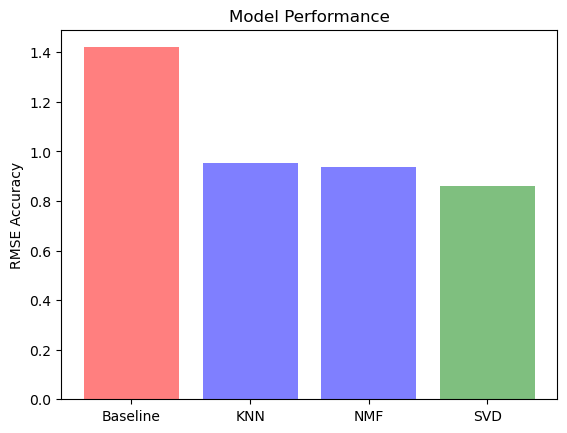

In [166]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Baseline', 'KNN', 'NMF', 'SVD')
y_pos = np.arange(len(objects))
performance = [baseline_rsme, knn_rsme, nmf_rsme, svd_rsme]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue', 'blue', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('RMSE Accuracy')
plt.title('Model Performance')

plt.show()

With all the best parameters calculated, our SVD model scored the lowest on RSME

### Final Model Evaluation

In [45]:
final_model = SVD(n_factors=125,n_epochs=45,lr_all=0.015,reg_all=0.1)

In [46]:
predictions = final_model.fit(train_data2).test(test_data2)

In [47]:
accuracy.rmse(predictions)

RMSE: 0.8610


0.8610326478922142

## Deployment

In [48]:
#create trainset object from surprise dataset
full_data = complete_data.build_full_trainset()

In [49]:
final_model.fit(full_data)

#### Function Building

In [50]:
#setting index to ensure dropping
userdf = movie_rating.set_index('userId')

In [51]:
userdf

,movieId,genres,Title,year_released,rating,timestamp
userId,,,,,,
1.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.0,2000-07-30 18:45:03
5.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.0,1996-11-08 06:36:02
7.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.5,2005-01-25 06:52:26
15.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,2.5,2017-11-13 12:59:30
17.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.5,2011-05-18 05:28:03
...,...,...,...,...,...,...
184.0,193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017,4.0,2018-09-16 14:44:42
184.0,193583,"animation, comedy, fantasy",No Game No Life: Zero,2017,3.5,2018-09-16 14:52:25
184.0,193585,drama,Flint,2017,3.5,2018-09-16 14:56:45


In [52]:
#create 
userdf1 = userdf['movieId']

In [53]:
userdf1.loc[9,]

userId
9.0      41
9.0     187
9.0     223
9.0     371
9.0     627
9.0     922
9.0     923
9.0    1037
9.0    1095
9.0    1198
9.0    1270
9.0    1674
9.0    1987
9.0    2011
9.0    2012
9.0    2023
9.0    2300
9.0    2877
9.0    2901
9.0    3173
9.0    3328
9.0    3735
9.0    4131
9.0    4558
9.0    4993
9.0    5218
9.0    5378
9.0    5445
9.0    5447
9.0    5451
9.0    5481
9.0    5507
9.0    5841
9.0    5843
9.0    5872
9.0    5890
9.0    5891
9.0    5893
9.0    5902
9.0    5952
9.0    5956
9.0    5962
9.0    5965
9.0    5988
9.0    6001
9.0    6044
Name: movieId, dtype: int64

In [54]:
user_rate = list(userdf1.loc[9,])

In [55]:
user_rate

[41,
 187,
 223,
 371,
 627,
 922,
 923,
 1037,
 1095,
 1198,
 1270,
 1674,
 1987,
 2011,
 2012,
 2023,
 2300,
 2877,
 2901,
 3173,
 3328,
 3735,
 4131,
 4558,
 4993,
 5218,
 5378,
 5445,
 5447,
 5451,
 5481,
 5507,
 5841,
 5843,
 5872,
 5890,
 5891,
 5893,
 5902,
 5952,
 5956,
 5962,
 5965,
 5988,
 6001,
 6044]

In [56]:
#setting index so we can drop base off of specific movieId
moviedf = movies.set_index('movieId')

In [57]:
moviedf

,genres,Title,year_released
movieId,,,
1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
2,"adventure, children, fantasy",Jumanji,1995
3,"comedy, romance",Grumpier Old Men,1995
4,"comedy, drama, romance",Waiting to Exhale,1995
5,comedy,Father of the Bride Part II,1995
...,...,...,...
193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
193585,drama,Flint,2017


In [58]:
moviedf.drop(user_rate, inplace = True)

In [59]:
moviedf

,genres,Title,year_released
movieId,,,
1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
2,"adventure, children, fantasy",Jumanji,1995
3,"comedy, romance",Grumpier Old Men,1995
4,"comedy, drama, romance",Waiting to Exhale,1995
5,comedy,Father of the Bride Part II,1995
...,...,...,...
193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
193585,drama,Flint,2017


In [60]:
#reset index to be able to use .apply on the movieId
moviedf = moviedf.reset_index()

In [61]:
moviedf

,movieId,genres,Title,year_released
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
1,2,"adventure, children, fantasy",Jumanji,1995
2,3,"comedy, romance",Grumpier Old Men,1995
3,4,"comedy, drama, romance",Waiting to Exhale,1995
4,5,comedy,Father of the Bride Part II,1995
...,...,...,...,...
9686,193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
9687,193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
9688,193585,drama,Flint,2017
9689,193587,"action, animation",Bungo Stray Dogs: Dead Apple,2018


In [62]:
moviedf['est_rating'] = moviedf['movieId'].apply(lambda x: final_model.predict(9, x).est)
moviedf.sort_values(by='est_rating', ascending=False, inplace=True)

In [63]:
moviedf.head(5)

,movieId,genres,Title,year_released,est_rating
8791,132333,"documentary, drama",Seve,2014,4.735453
5156,8477,"romance, sci-fi","Jetée, La",1962,4.630203
2264,3030,"action, adventure",Yojimbo,1961,4.538663
1871,2511,"crime, film-noir","Long Goodbye, The",1973,4.519377
4350,6460,drama,"Trial, The","Procès, Le (1962",4.516037


#### Function

In [64]:
#creating a variable that only has the userid and movies that they've rated
#this uses the original train dataset not surprise's version
users_movies_seen = movie_rating[['movieId', 'userId']]
#setting user id as index to make it easier to use loc on it
users_movies_seen = users_movies_seen.set_index('userId')

In [65]:
def recommender():
    user = float(input('userId: '))
    genre = input('What genres are you interested in? ')
    num_recs = int(input('How many recomendations would you like? '))

    #using the train data
    #create the seen_movie
    seen_movie = list(users_movies_seen.loc[user, 'movieId'])

    #create df with all the unseen/unrated movies
    train_copy = movies.copy()
    train_copy2 = train_copy.set_index('movieId')

    #using the not_seen df, create a rating for a user
    not_seen = train_copy2.drop(index = seen_movie)

    #subsetting the df to unseen movies of a certain genre
    not_seen = not_seen[not_seen['genres'].str.contains(genre)]
    
    #reset not_seen index
    not_seen = not_seen.reset_index()
    
    #creating an est rating and the sorted it
    not_seen['est_rating'] = not_seen['movieId'].apply(lambda x: final_model.predict(user, x).est)
    not_seen.sort_values(by='est_rating', ascending=False, inplace=True)

    #returns the recommendations that the model predicts to be the highest rating
    return (not_seen.head(num_recs))

In [218]:
def recommender2():
    user = float(input('userId: '))
    genre = input('What genres are you interested in? ').split(' ')
    num_recs = int(input('How many recomendations would you like? '))

    #using the train data
    #create the seen_movie
    seen_movie = list(users_movies_seen.loc[user, 'movieId'])

    #create df with all the unseen/unrated movies
    train_copy = movies.copy()
    train_copy2 = train_copy.set_index('movieId')

    #using the not_seen df, create a rating for a user
    not_seen = train_copy2.drop(index = seen_movie)

    #subsetting the df to unseen movies of a certain genre
    seen_test = pd.DataFrame(columns=['genres', 'Title', 'year_released'])
    for x in genre:
        for row, data in not_seen.iterrows():
            if x in not_seen['genres'][row]:
                seen_test.loc[row] = list(not_seen.loc[row,:])
    
    #reset not_seen index
    seen_test = seen_test.reset_index()
    
    #creating an est rating and the sorted it
    seen_test['est_rating'] = seen_test['index'].apply(lambda x: final_model.predict(user, x).est)
    seen_test.sort_values(by='est_rating', ascending=False, inplace=True)

    #returns the recommendations that the model predicts to be the highest rating
    return (seen_test[['Title', 'genres']].head(num_recs))

In [219]:
recommender2()

userId: 10
What genres are you interested in? action adventure comedy
How many recomendations would you like? 10


,Title,genres
4750,Submarine,"comedy, drama, romance"
2336,"Day of the Doctor, The","adventure, drama, sci-fi"
5409,Isle of Dogs,"animation, comedy"
4267,Saving Face,"comedy, drama, romance"
3961,Adam's Rib,"comedy, romance"
910,Neon Genesis Evangelion: The End of Evangelion,"action, animation, drama, fantasy, sci-fi"
2662,It Happened One Night,"comedy, romance"
4653,Gentlemen of Fortune,"comedy, crime, drama, mystery"
1756,Band of Brothers,"action, drama, war"
3827,Belle époque,"comedy, romance"
